# Bagging

por Mónica Tatiana Gutierrez Ballen

version 1.0, Agosto 2021

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Rick Muller](http://www.cs.sandia.gov/~rmuller/), Sandia National Laboratories


¿Por qué estamos aprendiendo sobre ensamblaje?

- Método muy popular para mejorar el rendimiento predictivo de los modelos de aprendizaje automático
- Proporciona una base para entender modelos más sofisticados

## Objetivos de la lección

Los alumnos serán capaces de:

- Definir el ensamblaje y sus requisitos
- Identificar los dos métodos básicos de ensamblaje
- Decidir si el ensamblaje manual es un enfoque útil para un problema determinado
- Explicar el ensamblaje y cómo puede aplicarse a los árboles de decisión
- Explicar cómo se calcula el error fuera de bolsa y la importancia de las características de los árboles ensamblados
- Explicar la diferencia entre los árboles ensamblados y los bosques aleatorios
- Construir y ajustar un modelo de Bosque Aleatorio en scikit-learn
- Decidir si un árbol de decisión o un bosque aleatorio es el mejor modelo para un problema determinado.


# Parte 1: Introducción

El aprendizaje por conjuntos es un tema muy estudiado en la comunidad del aprendizaje automático. La idea principal de la metodología de conjuntos es combinar varios clasificadores base individuales para tener un clasificador que supere a cada uno de ellos.

Hoy en día, los métodos de ensemble son una de las técnicas de aprendizaje automático más populares y estudiadas, y se puede observar que desde 2009 todos los ganadores del primer y segundo puesto de la KDD-Cup https://www.sigkdd.org/kddcup/ utilizaron métodos de ensemble. El principio básico El principio básico del aprendizaje por conjuntos es inducir perturbaciones aleatorias en el procedimiento de para producir varios clasificadores base diferentes a partir de un único conjunto de entrenamiento, y luego combinar los combinando los clasificadores de base para hacer la predicción final.  Para inducir las permutaciones aleatorias y crear así los diferentes clasificadores de base, se han propuesto varios métodos, en en particular: 
* bagging
* boosting
* bosques aleatorios

Finalmente, después de que los clasificadores base están entrenados, normalmente se combinan usando:
* votación por mayoría
* votación ponderada  
* stacking

Hay tres razones principales por las que los métodos de conjunto que los modelos individuales: estadístico, computacional y de representación. 
* En primer lugar, desde el punto de vista estadístico, cuando el conjunto de aprendizaje es muy pequeño, un algoritmo puede encontrar varios modelos buenos dentro del espacio de búsqueda, que surgen al mismo rendimiento en el conjunto de entrenamiento $\mathcal{S}$. No obstante, sin un conjunto de validación, existe riesgo de elegir el modelo equivocado. 
* La segunda razón es computacional; en general, los algoritmos dependen de alguna optimización de búsqueda local y pueden quedarse atascados en un óptimo local. Entonces, un conjunto puede resolver esto enfocando diferentes algoritmos a diferentes espacios a través del conjunto de entrenamiento. 
* La última razón es la representación. En la mayoría de los casos, para un conjunto de aprendizaje de tamaño finito, la función verdadera $f$ no puede ser representada por ninguno de los modelos candidatos. Al combinar varios modelos en un de modelos en un conjunto, puede ser posible obtener un modelo con una mayor cobertura en el espacio de funciones representables.

## Ejemplo

Supongamos que en lugar de construir un único modelo para resolver un problema de clasificación binaria, creas **cinco modelos independientes**, y que cada modelo acierta un 70% de las veces. Si se combinan estos modelos en un "conjunto" y se utiliza su voto mayoritario como predicción, ¿con qué frecuencia sería correcto el conjunto?

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print(preds1[:20])
print(preds2[:20])
print(preds3[:20])
print(preds4[:20])
print(preds5[:20])

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [ ]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print(ensemble_preds[:20])

[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


In [ ]:
# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

0.713
0.665
0.717
0.712
0.687


In [ ]:
# how accurate was the ensemble?
print(ensemble_preds.mean())

0.841


**Nota:** A medida que se añaden más modelos al proceso de votación, la probabilidad de error disminuye, lo que se conoce como [Teorema del Jurado de Condorcet](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## ¿Qué es el ensembling?

**El aprendizaje por conjuntos (o "ensembling")** es el proceso de combinar varios modelos de predicción para producir un modelo combinado que sea más preciso que cualquier modelo individual.

- **Regresión:** tomar la media de las predicciones
- **Clasificación:** se vota y se utiliza la predicción más común, o se toma la media de las probabilidades predichas.

Para que el ensamblaje funcione bien, los modelos deben tener las siguientes características

- **Precisos:** superan al modelo nulo
- **Independientes:** sus predicciones se generan mediante procesos diferentes

**La gran idea:** Si se tiene una colección de modelos individualmente imperfectos (e independientes), los errores "puntuales" cometidos por cada modelo probablemente no serán cometidos por el resto de los modelos, y por lo tanto los errores serán descartados al promediar los modelos.

Existen dos **métodos básicos para el ensamblaje:**

- Ensamblar manualmente los modelos individuales
- Utilizar un modelo que ensambla por ti

### Rendimiento teórico de un conjunto

Si suponemos que cada uno de los clasificadores base $T$ tiene una probabilidad $\rho$ de de ser correcto, la probabilidad de que un conjunto tome la decisión correcta, asumiendo la independencia denotada por $P_c$, puede calcularse mediante la distribución binomial

$$P_c = \sum_{j>T/2}^{T} {{T}\choose{j}} \rho^j(1-\rho)^{T-j}.$$

Además, como se muestra, si $T\ge3$ entonces:

$$
  \lim_{T \to  \infty} P_c= \begin{cases} 
            1  &\mbox{if } \rho>0.5 \\ 
            0  &\mbox{if } \rho<0.5 \\ 
            0.5  &\mbox{if } \rho=0.5 ,
            \end{cases}
$$
lo que lleva a la conclusión de que 
$$
  \rho \ge 0.5 \quad \text{and} \quad T\ge3 \quad \Rightarrow \quad P_c\ge \rho.
$$

# Parte 2: Ensamblaje manual

¿Qué hace que un conjunto manual sea bueno?

- Diferentes tipos de **modelos**
- Diferentes combinaciones de **funciones**
- Diferentes **parámetros de ajuste**

![Machine learning flowchart](https://raw.githubusercontent.com/justmarkham/DAT8/master/notebooks/images/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*

In [ ]:
# read in and prepare the vehicle training data
import pandas as pd
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/vehicles_train.csv'
train = pd.read_csv(url)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
# read in and prepare the vehicle testing data
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})

In [ ]:
train.head()

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0


### Entrenar diferentes modelos

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

models = {'lr': LinearRegression(),
          'dt': DecisionTreeRegressor(),
          'rd': Ridge(alpha=0, normalize=True),
          'ls': Lasso(alpha=0.001, normalize=True)}

In [ ]:
# Train all the models
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
y_train = train.price
y_test = test.price

for model in models.keys():
    models[model].fit(X_train, y_train)

In [ ]:
# predict test for each model
y_pred = pd.DataFrame(index=test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)
y_pred    

,lr,dt,rd,ls
0,5909.172251,4000.0,5909.172251,5909.156609
1,7870.639018,5000.0,7870.639018,7870.639531
2,13324.820758,14000.0,13324.820758,13324.816009


In [ ]:
# Evaluate each model
from sklearn.metrics import mean_squared_error

for model in models.keys():
    print(model,"RMSE: ", np.sqrt(mean_squared_error(y_pred[model], y_test)))

lr RMSE:  2138.3579028745116
dt RMSE:  1414.213562373095
rd RMSE:  2138.3579028745116
ls RMSE:  2138.3499784143114


### Evaluar el error de la media de las predicciones

In [ ]:
print("RMSE: ",np.sqrt(mean_squared_error(y_pred.mean(axis=1), y_test)))

RMSE:  1777.1008942261117


# Parte 3: Bagging

La principal debilidad de los **árboles de decisión** es que no suelen tener la mejor precisión predictiva. Esto se debe en parte a la **alta varianza**, lo que significa que diferentes divisiones en los datos de entrenamiento pueden dar lugar a árboles muy diferentes.

El **Bagging** es un procedimiento de propósito general para reducir la varianza de un método de aprendizaje automático, pero es particularmente útil para los árboles de decisión. Bagging es la abreviatura de **agregación bootstrap**, es decir, la agregación de muestras bootstrap.

¿Qué es una **muestra bootstrap**? Una muestra aleatoria con reemplazo:

In [ ]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print(nums)

# sample that array 20 times with replacement
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**¿Cómo funciona el bagging (para los árboles de decisión)?**

1. Cree B árboles utilizando B muestras bootstrap de los datos de entrenamiento.
2. Entrenar cada árbol con su muestra bootstrap y hacer predicciones.
3. Combine las predicciones:
    - Promediar las predicciones para los **árboles de regresión**.
    - Realice una votación para los **árboles de clasificación**.

Notas:

- **Cada muestra bootstrap** debe tener el mismo tamaño que el conjunto de entrenamiento original.
- **B** debe ser un valor lo suficientemente grande como para que el error parezca haberse "estabilizado".
- Los árboles se **crean en profundidad** para que tengan un sesgo bajo/una varianza alta.

El ensacado aumenta la precisión de la predicción al **reducir la varianza**, de forma similar a como la validación cruzada reduce la varianza asociada a la división de entrenamiento/prueba (para estimar el error fuera de la muestra) al dividir muchas veces y promediar los resultados.


In [ ]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [ ]:
# show the rows for the first decision tree
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


 Construir un árbol para cada muestra

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

predictions = []

for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    
    treereg.fit(X_train, y_train)
    
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)
    
predictions

[array([ 1300.,  5000., 14000.]),
 array([ 1300.,  1300., 13000.]),
 array([ 3000.,  3000., 13000.]),
 array([ 4000.,  5000., 13000.]),
 array([ 1300.,  5000., 13000.]),
 array([ 4000.,  5000., 14000.]),
 array([ 4000.,  4000., 13000.]),
 array([ 4000.,  5000., 13000.]),
 array([3000., 5000., 9500.]),
 array([4000., 5000., 9000.])]

In [ ]:
y_test

0     3000
1     6000
2    12000
Name: price, dtype: int64

Resultados de cada árbol

In [ ]:
#We average the predictions of each "y"
np.mean(predictions, axis=0)

array([ 2990.,  4330., 12450.])

Resultados del conjunto

In [ ]:
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE:  998.5823284370031


## Árboles de decisión en bolsa en scikit-learn (con B=500)

In [ ]:
# define the training and testing sets
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [ ]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1)

In [ ]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3335. ,  5419.8, 12956. ])

In [ ]:
# calculate RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

673.9913550385247

## Estimación del error fuera de la muestra

Para los modelos empaquetados, el error fuera de la muestra puede estimarse sin utilizar la **división entrenamiento/prueba** o la **validación cruzada**.

Por término medio, cada árbol empaquetado utiliza unos **dos tercios** de las observaciones. Para cada árbol, las **observaciones restantes** se denominan observaciones "fuera de bolsa".

In [ ]:
# show the first bootstrap sample
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [ ]:
# show the "in-bag" observations for each sample
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [ ]:
# show the "out-of-bag" observations for each sample
for sample in samples:
    print(sorted(set(range(n_samples)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


Cómo calcular el **"error de salida de bolsa"**

1. Para cada observación de los datos de entrenamiento, prediga su valor de respuesta utilizando **sólo** los árboles en los que esa observación estaba fuera de bolsa. Promueva esas predicciones (para la regresión) o haga una votación (para la clasificación).
2. Compare todas las predicciones con los valores de respuesta reales para calcular el error fuera de bolsa.

Cuando B es suficientemente grande, el **error fuera de bolsa** es una estimación precisa del **error fuera de muestra**.

In [ ]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for B=500
bagreg.oob_score_

0.7662607997982768

## Estimación de la importancia de las características

El empaquetamiento aumenta la **precisión predictiva**, pero disminuye la **interpretabilidad del modelo** porque ya no es posible visualizar el árbol para entender la importancia de cada característica.

Sin embargo, podemos obtener un resumen general de la **importancia de las características** a partir de los modelos empaquetados:

- **Árboles de regresión empaquetados:** calculan la cantidad total de **MSE** que disminuye debido a las divisiones de una característica determinada, promediando todos los árboles.
- **Árboles de clasificación empaquetados:** calculan la cantidad total que el índice de Gini disminuye debido a las divisiones de una característica determinada, promediando todos los árboles.

# Parte 4: Combinación de clasificadores - Votación por mayoría

La forma más típica de un conjunto se hace combinando $T$ diferentes clasificadores de base. Cada clasificador base $M(\mathcal{S}_j)$ se entrena aplicando el algoritmo $M$ a un subconjunto aleatorio $\mathcal{S}_j$ del conjunto de entrenamiento $\mathcal{S}$.  
Para simplificar definimos $M_j \equiv  M(\mathcal{S}_j)$ para $j=1,\dots,T$, y $\mathcal{M}=\{M_j\}_{j=1}^{T}$ un conjunto de clasificadores base. A continuación, estos modelos se combinan utilizando la votación por mayoría para crear el conjunto $H$ de la siguiente manera $$
    f_{mv}(\mathcal{S},\mathcal{M}) = max_{c \in \{0,1\}} \sum_{j=1}^T 
    \mathbf{1}_c(M_j(\mathcal{S})).
  $$

In [ ]:
# read in and prepare the churn data
# Download the dataset
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/churn.csv'
data = pd.read_csv(url)

# Create X and y

# Select only the numeric features
X = data.iloc[:, [1,2,6,7,8,9,10]].astype(np.float)
# Convert bools to floats
X = X.join((data.iloc[:, [4,5]] == 'no').astype(np.float))

y = (data.iloc[:, -1] == 'True.').astype(np.int)

In [ ]:
X.head()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Int'l Plan,VMail Plan
0,128.0,415.0,25.0,265.1,110.0,45.07,197.4,1.0,0.0
1,107.0,415.0,26.0,161.6,123.0,27.47,195.5,1.0,0.0
2,137.0,415.0,0.0,243.4,114.0,41.38,121.2,1.0,1.0
3,84.0,408.0,0.0,299.4,71.0,50.90,61.9,0.0,1.0
4,75.0,415.0,0.0,166.7,113.0,28.34,148.3,0.0,1.0


In [ ]:
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,2850,0.855086
1,483,0.144914


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Crear 100 árboles de decisión

In [ ]:
n_estimators = 100
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [ ]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
438,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1345,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,1,0
1957,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
2148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


Predicción por mayoría

In [ ]:
y_pred_df.sum(axis=1)[:10]

438      2
2674     5
1345    35
1957    17
2148     3
3106     4
1786    22
321      6
3082    10
2240     5
dtype: int64

In [ ]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.5245901639344264

In [ ]:
metrics.accuracy_score(y_pred, y_test)

0.8945454545454545

### Uso de la votación por mayoría con sklearn

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5241935483870966, 0.8927272727272727)

# Parte 5: Combinación de clasificadores - Votación ponderada

El enfoque de la votación por mayoría da el mismo peso a cada clasificador independientemente del rendimiento de cada uno. ¿Por qué no tener en cuenta el rendimiento oob de cada clasificador?

En primer lugar, en el enfoque tradicional, se realiza una comparación similar de los votos de los clasificadores base, pero dando un peso $\alpha_j$ a cada clasificador $M_j$ durante la fase de votación
$$
  f_{wv}(\mathcal{S},\mathcal{M}, \alpha)
  =\max_{c \in \{0,1\}} \sum_{j=1}^T \alpha_j \mathbf{1}_c(M_j(\mathcal{S})),
$$
donde $\alpha=\{\alpha_j\}_{j=1}^T$.
El cálculo de $\alpha_j$ está relacionado con el rendimiento de cada clasificador $M_j$.
Suele definirse como el error de clasificación normalizado $\epsilon$ del clasificador base clasificador $M_j$ en el conjunto fuera de bolsa $\mathcal{S}_j^{oob}=\mathcal{S}-\mathcal{S}_j$

\begin{equation}
  \alpha_j=\frac{1-\epsilon(M_j(\mathcal{S}_j^{oob}))}{\sum_{j_1=1}^T 
  1-\epsilon(M_{j_1}(\mathcal{S}_{j_1}^{oob}))}.
\end{equation}

Seleccione cada muestra oob

In [ ]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))   

Estimar el error oob de cada clasificador

In [ ]:
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

In [ ]:
errors

array([0.17775091, 0.17904994, 0.20904645, 0.18712753, 0.19266055,
       0.17433414, 0.18147685, 0.18569636, 0.19488429, 0.16438356,
       0.1791411 , 0.17598098, 0.19013237, 0.17889908, 0.19076549,
       0.17625   , 0.1803681 , 0.20989144, 0.17279412, 0.1836983 ,
       0.19263804, 0.18170732, 0.18704156, 0.18245614, 0.17364532,
       0.19949174, 0.16436637, 0.18704156, 0.17724551, 0.17326733,
       0.1593674 , 0.17428925, 0.16904762, 0.18590522, 0.18896714,
       0.18668252, 0.18087558, 0.17135863, 0.18483412, 0.18727491,
       0.18478261, 0.1459854 , 0.17472119, 0.17753623, 0.18995098,
       0.20096852, 0.18697226, 0.18102372, 0.19343066, 0.15636364,
       0.17010936, 0.18203883, 0.1744325 , 0.18421053, 0.16121495,
       0.18979834, 0.19406675, 0.18014706, 0.19824341, 0.19515152,
       0.18734491, 0.17775091, 0.20479042, 0.18292683, 0.19903498,
       0.18091698, 0.18469016, 0.18988903, 0.19259259, 0.1872705 ,
       0.18113208, 0.1840796 , 0.19354839, 0.1968599 , 0.17034

Text(0.5, 1.0, 'OOB error of each tree')

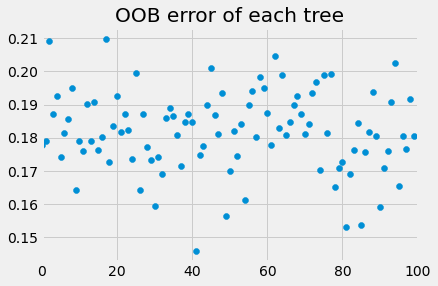

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')

Estimar $\alpha$

In [ ]:
alpha = (1 - errors) / (1 - errors).sum()

In [ ]:
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

In [ ]:
weighted_sum_1.shape

(1100,)

In [ ]:
weighted_sum_1.head(20)

438     0.019994
2674    0.050009
1345    0.350206
1957    0.170230
2148    0.030047
3106    0.040100
1786    0.219790
321     0.059708
3082    0.100208
2240    0.050143
1910    0.180209
2124    0.190141
2351    0.049892
1736    0.950014
879     0.039378
785     0.219648
2684    0.010104
787     0.700482
170     0.220404
1720    0.020166
dtype: float64

In [ ]:
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5267489711934156, 0.8954545454545455)

### Uso del voto ponderado con sklearn

In [ ]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5241935483870966, 0.8927272727272727)

In [ ]:
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [ ]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5418326693227091, 0.8954545454545455)

# Parte 6: Combinación de clasificadores - Stack

El método stack consiste en combinar los diferentes clasificadores de base mediante el aprendizaje de un algoritmo de segundo nivel sobre ellos. En este marco, una vez que los clasificadores base se construyen utilizando el conjunto de entrenamiento $\mathcal{S}$, se construye un nuevo conjunto donde la salida de los clasificadores de base se considera ahora como las características, manteniendo las etiquetas de clase.

Aunque no hay ninguna restricción sobre el algoritmo que se puede utilizar como aprendiz de segundo nivel, es habitual utilizar un modelo lineal, como 
$$
  f_s(\mathcal{S},\mathcal{M},\beta) =
  g \left( \sum_{j=1}^T \beta_j M_j(\mathcal{S}) \right),
$$
donde $\beta=\{beta_j\}_{j=1}^T$, y $g(\cdot)$ es la función de signo $g(z)=sign(z)$ en el caso de una regresión lineal o la función sigmoide, definida como como $g(z)=1/(1+e^{-z})$, en el caso de una regresión logística. 

In [ ]:
from IPython.display import Image
Image(url= "http://www.chioka.in/wp-content/uploads/2013/09/stacking-580x387.png", width=900)


Obtengamos primero un nuevo conjunto de entrenamiento formado por la salida de cada clasificador

In [ ]:
X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    X_train_2[i] = trees[i].predict(X_train)

In [ ]:
X_train_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1412,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
626,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
lr = LogisticRegressionCV(cv = 5)
lr.fit(X_train_2, y_train)

LogisticRegressionCV(cv=5)

In [ ]:
lr.coef_

array([[0.10088464, 0.10421338, 0.09358074, 0.09660953, 0.09697781,
        0.09904032, 0.11090891, 0.09651815, 0.0935383 , 0.09123672,
        0.10193353, 0.09820731, 0.09391233, 0.09549362, 0.09152095,
        0.09644657, 0.0896993 , 0.09192601, 0.09677729, 0.09012681,
        0.09833482, 0.09514   , 0.10454839, 0.10039995, 0.09661211,
        0.09730309, 0.10910644, 0.10590111, 0.10264443, 0.10275915,
        0.10611423, 0.09792985, 0.1031922 , 0.09266752, 0.09697419,
        0.09517301, 0.08893016, 0.0989854 , 0.09045676, 0.09011887,
        0.09902678, 0.09876865, 0.10538597, 0.09571805, 0.09629428,
        0.08972837, 0.09176166, 0.08990744, 0.10143139, 0.10831536,
        0.10061968, 0.09763531, 0.08939132, 0.10073731, 0.10174935,
        0.10527521, 0.0975041 , 0.0960247 , 0.0893913 , 0.10042684,
        0.10342512, 0.10139005, 0.0902557 , 0.10340747, 0.09330728,
        0.09808251, 0.10159091, 0.0931049 , 0.0952795 , 0.1103413 ,
        0.09358935, 0.09856276, 0.10599656, 0.09

In [ ]:
y_pred = lr.predict(y_pred_df)

In [ ]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5365853658536585, 0.8963636363636364)

### Uso de sklearn

In [ ]:
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_3 = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):

    X_train_3[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_3, y_train)

y_pred = lr.predict(y_pred_all_)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5625000000000001, 0.8981818181818182)

frente a la utilización de un solo árbol de decisión

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.44378698224852065, 0.8290909090909091)